In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

%cd ../..

!hostname

/p/fastdata/pli/Private/oberstrass1/datasets/vervet1818-3d
jrlogin12.jureca


In [2]:
import os

import re
import pandas as pd
import numpy as np

import pli
import pli.image as im

from tqdm import tqdm

In [3]:
feature_path = "data/aa/features/resnet50_planes8_overlap/"
mask_path = "data/aa/masks/cortex/"

###

p = re.compile('.*s([0-9]{4})_.*')

feature_list = []
for f in sorted(os.listdir(feature_path)):
    id = int(p.match(f)[1])
    feature_list.append({'id': id, 'file': os.path.join(feature_path, f)})
feature_df = pd.DataFrame(feature_list).sort_values('id').reset_index(drop=True)

mask_list = []
for f in sorted(os.listdir(mask_path)):
    id = int(p.match(f)[1])
    mask_list.append({'id': id, 'file': os.path.join(mask_path, f)})
mask_df = pd.DataFrame(mask_list).sort_values('id').reset_index(drop=True)

files_df = mask_df.merge(feature_df, on='id', how='left', suffixes=('_mask', '_feature'))

files_df.head()

,id,file_mask,file_feature
0,841,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,data/aa/features/resnet50_planes8_overlap/Verv...
1,842,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,data/aa/features/resnet50_planes8_overlap/Verv...
2,843,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,data/aa/features/resnet50_planes8_overlap/Verv...
3,844,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,data/aa/features/resnet50_planes8_overlap/Verv...
4,845,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,data/aa/features/resnet50_planes8_overlap/Verv...


In [4]:
def read_section(feature_path, mask_path, mask_pyramid, data_group, mask_group='Image'):

    feature_section = pli.data.Section(feature_path, data_group=data_group)
    mask_section = pli.data.Section(mask_path, data_group=mask_group)

    spacing = mask_section.spacing

    mask = mask_section.pyramid[mask_pyramid][:]
    features = feature_section.image[:].transpose(1, 2, 0)

    if features.shape[0] >  mask.shape[0]:
        features = features[:-1]
    if features.shape[1] >  mask.shape[1]:
        features = features[:, :-1]

    feature_section.close_file_handle()
    mask_section.close_file_handle()

    return features, mask, spacing

In [14]:
# Fit PCA by subsample of the data

n_subsamples = 64  # len(files_df)  # Number of randomly selected sections, go for 234 in the end!!
seed = 299792458

# Group of the features in the H5 files
data_group = 'Features/256'

# Coressponding pyramid to the Feature size
mask_pyramid = 6

# Smoothing of the features
# sigma = 1.0

###

from skimage import filters
import numpy as np

from tqdm import tqdm

np.random.seed(seed)

selected_features = []
selected_masks = []

for k, r in tqdm(files_df.sample(n_subsamples).sort_values('id').iterrows(), total=n_subsamples):
    features, mask, spacing = read_section(r.file_feature, r.file_mask, mask_pyramid=mask_pyramid, data_group=data_group)
    assert features.shape[:2] == mask.shape, f"{features.shape[:2]} differs from {mask.shape}"

    # Smooth features a bit
    # features_smoothed = filters.gaussian(features, multichannel=True, sigma=sigma)

    selected_features.append(features)
    selected_masks.append(mask)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:13<00:00,  4.59it/s]


In [15]:
# Get data points without background

WM = 1
GM = 2
BG = 3

###

valid_features = [f[m != BG] for f, m in zip(selected_features, selected_masks)]
valid_lengths = [len(vf) for vf in valid_features]
valid_features = np.vstack(valid_features)

In [16]:
pca_components = len(valid_features[0])

###

from sklearn.decomposition import PCA

pca = PCA(n_components=pca_components, svd_solver='full')
pca.fit(valid_features)

PCA(n_components=256, svd_solver='full')

Explained variance: 83.27% with 25 components


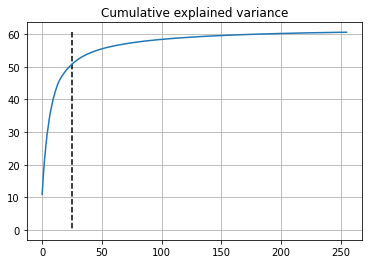

In [17]:
n_components = 25

###

import matplotlib.pyplot as plt

scree = np.cumsum(pca.explained_variance_)

print(f"Explained variance: {100 * scree[n_components -1] / scree[-1]:.2f}% with {n_components} components")
plt.plot(scree)
plt.vlines(n_components, scree.max(), 0, colors='black', linestyles='--')
plt.title("Cumulative explained variance")
plt.grid()
plt.show()

TODO: Use [cuML](https://github.com/rapidsai/cuml) here

Test
---

Sections 841-843 were unseen during training of contrastive features

In [18]:
# TODO: Clone all

test_sections = files_df.id #  [841, 860, 961, 1061]

###

test_files_df = files_df[files_df.id.isin(test_sections)]
test_files_df = test_files_df.reset_index(drop=True)

test_files_df.head()

,id,file_mask,file_feature
0,841,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,data/aa/features/resnet50_planes8_overlap/Verv...
1,842,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,data/aa/features/resnet50_planes8_overlap/Verv...
2,843,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,data/aa/features/resnet50_planes8_overlap/Verv...
3,844,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,data/aa/features/resnet50_planes8_overlap/Verv...
4,845,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,data/aa/features/resnet50_planes8_overlap/Verv...


In [19]:
# Apply the fitted PCA to the test sections

# Read test image for visualization
# test_features = []
test_pca = []
test_masks = []
test_spacings = []

for k, r in tqdm(test_files_df.iterrows(), total=len(test_files_df)):
    # Load features and mask
    features, mask, spacing = read_section(r.file_feature, r.file_mask, mask_pyramid=mask_pyramid, data_group=data_group)

    # Smooth features a bit
    # features = filters.gaussian(features, multichannel=True, sigma=sigma)

    # test_features.append(features)
    test_masks.append(mask)
    test_spacings.append(spacing)

    # Create PCA
    valid_test = features[mask != BG]
    valid_pca = pca.transform(valid_test)
    image_pca = np.zeros_like(features)
    image_pca[ mask != BG] = valid_pca

    test_pca.append(image_pca)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [04:15<00:00,  1.10s/it]


In [20]:
# Store PCA Maps

pca_dir = "..."

###

#for tpca, (k, r) in tqdm(zip(test_pca, test_files_df.iterrows()), total=len(test_files_df)):
#    print(f"{r.id}:")
#    im.show(np.stack([tpca[..., i] for i in range(n_components)]), ch='NHW', size=4)

In [11]:
n_clusters = 20
n_subfeatures = 32000
seed = 299792458

###

# Reduce to the selected valid components

valid_components = pca.transform(valid_features)[:, :n_components]
valid_components.shape

from sklearn.cluster import KMeans

np.random.seed(seed)

ix = np.random.choice(np.arange(len(valid_components)), n_subfeatures)

km = KMeans(n_clusters, n_init=5, max_iter=300, tol=1e-4, random_state=seed)
km.fit(valid_components[ix])

KMeans(n_clusters=20, n_init=5, random_state=299792458)

In [14]:
test_kmeans = []

for tpcas, tm, (k, r) in tqdm(zip(test_pca, test_masks, test_files_df.iterrows()), total=len(test_files_df)):
    test_predictions = km.predict(tpcas[tm != BG][..., :n_components])
    image_clusters = np.zeros(tm.shape[:2], dtype=np.uint8)
    image_clusters[tm != BG] = test_predictions

    test_kmeans.append(image_clusters)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:17<00:00, 13.27it/s]


id                                                            842
file_mask       data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...
file_feature    data/aa/features/resnet50_planes8_overlap/Verv...
Name: 1, dtype: object:
Warning! Printing mask for non integer like array


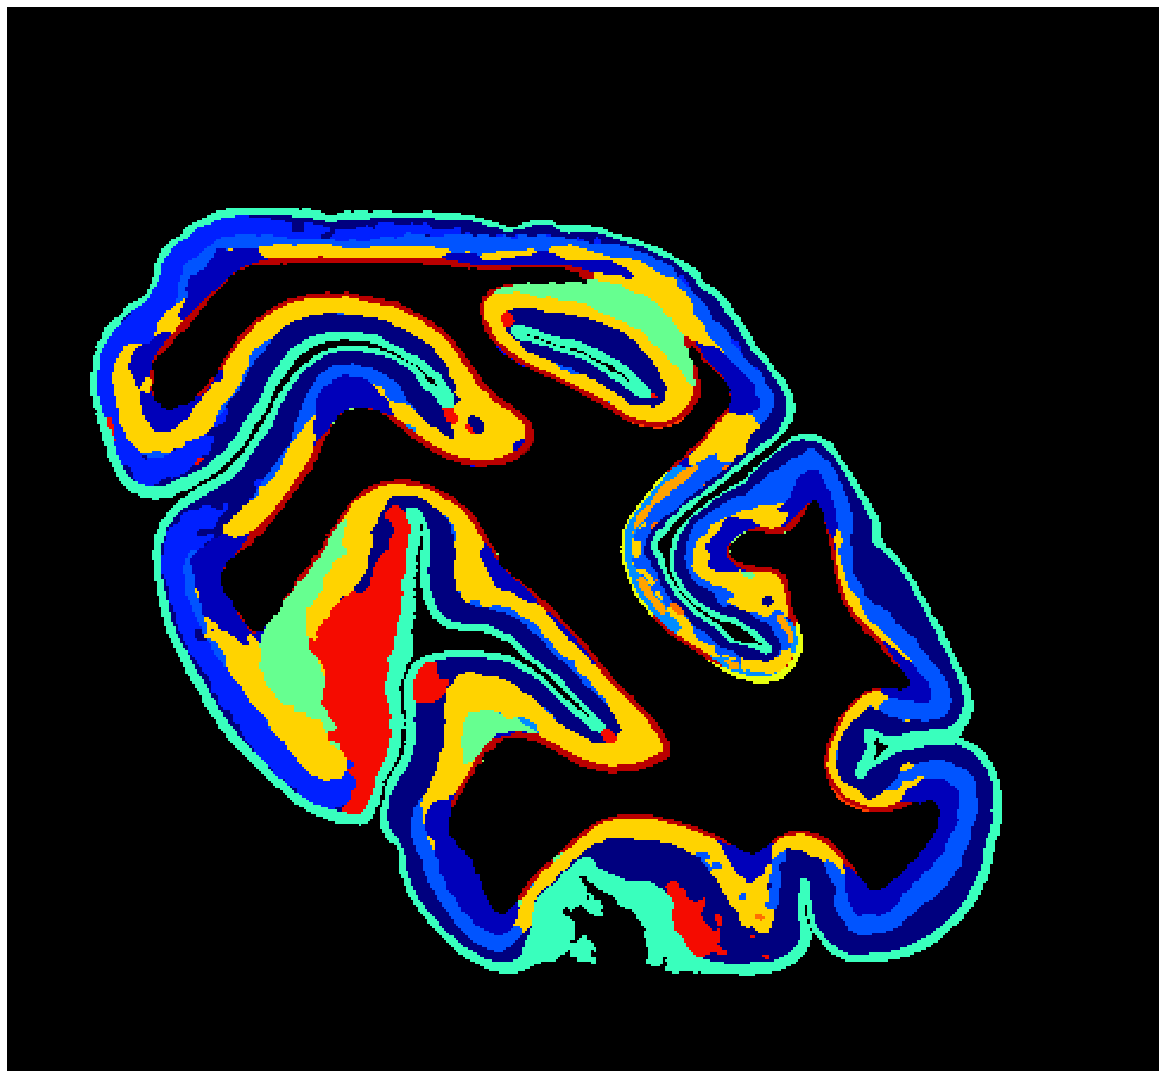

Warning! Printing mask for non integer like array


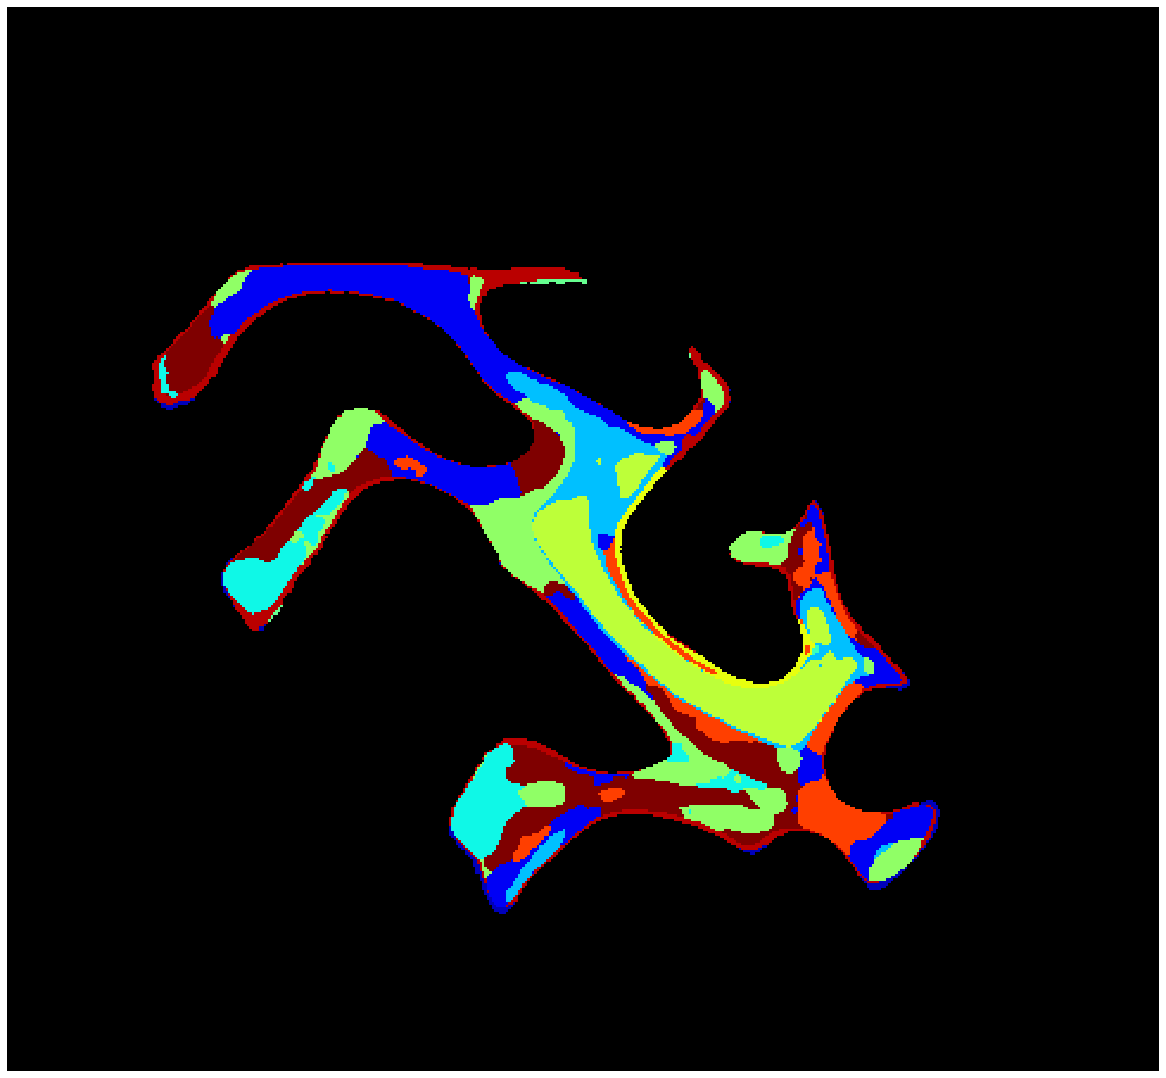

In [21]:
# Example clusters

ix = 1

###

print(f"{test_files_df.loc[ix]}:")

im.show(test_kmeans[ix], mask=test_masks[ix] != GM, size=16, cmap='jet', mask_map='gray', alpha=1.0, interpolation='nearest')
im.show(test_kmeans[ix], mask=test_masks[ix] != WM, size=16, cmap='jet', mask_map='gray', alpha=1.0, interpolation='nearest')

In [16]:
n_mappings = 20

###

from sklearn.cluster import AgglomerativeClustering

# linkage{‘ward’, ‘complete’, ‘average’, ‘single’}
ac = AgglomerativeClustering(n_mappings, affinity='euclidean', linkage='ward')
cluster_mapping = ac.fit_predict(km.cluster_centers_)

In [17]:
# Apply agllomerative clustering to the kmeans clusters

test_agglomerative = []

for tkm, tm, (k, r) in tqdm(zip(test_kmeans, test_masks, test_files_df.iterrows()), total=len(test_files_df)):
    aggl_predictions = cluster_mapping[tkm].astype(np.uint8)

    image_clusters = np.zeros(tm.shape[:2], dtype=np.uint8)
    image_clusters[tm != BG] =  aggl_predictions[tm != BG]

    test_agglomerative.append(image_clusters)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 1366.56it/s]


id                                                            842
file_mask       data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...
file_feature    data/aa/features/resnet50_planes8_overlap/Verv...
Name: 1, dtype: object:
Warning! Printing mask for non integer like array


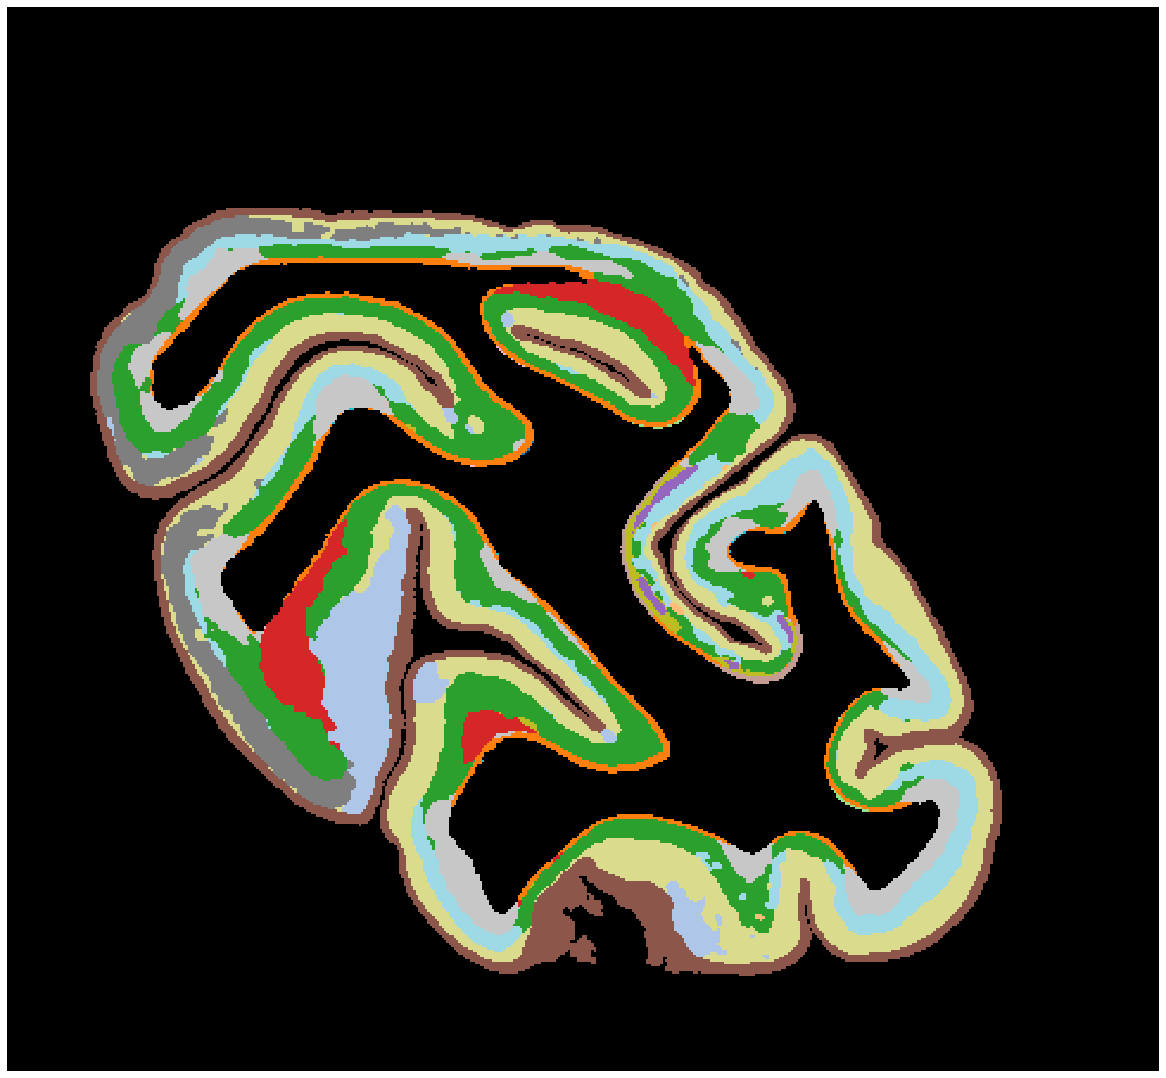

Warning! Printing mask for non integer like array


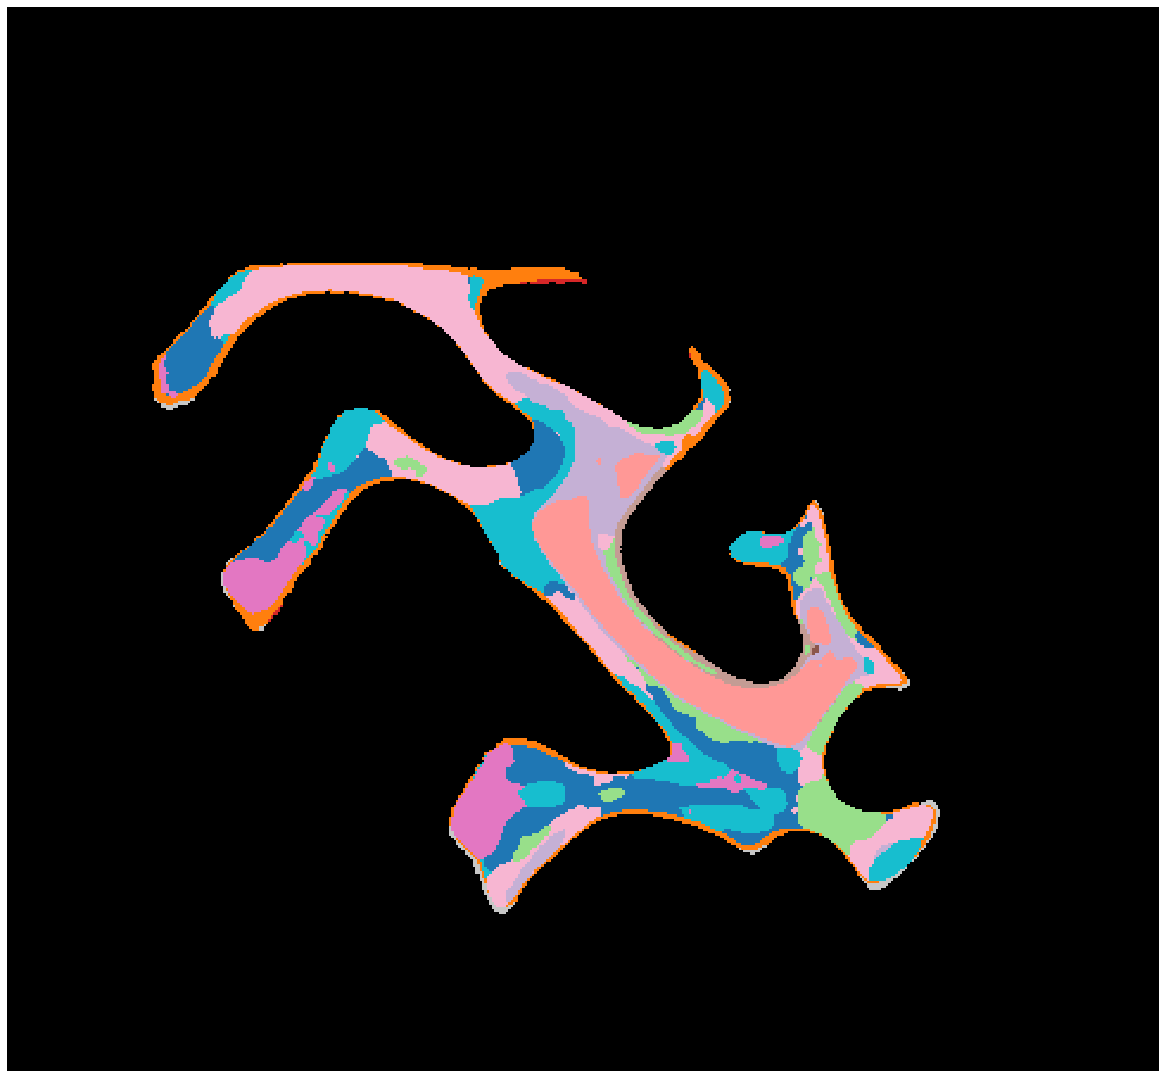

In [22]:
# Example clusters

ix = 1

###

print(f"{test_files_df.loc[ix]}:")

im.show(test_agglomerative[ix], mask=test_masks[ix] != GM, size=16, cmap='tab20', mask_map='gray', alpha=1.0, interpolation='nearest')
im.show(test_agglomerative[ix], mask=test_masks[ix] != WM, size=16, cmap='tab20', mask_map='gray', alpha=1.0, interpolation='nearest')

In [52]:
# Save volume

out_file = f"data/aa/clusters/agglomerative/reset50_planes8_overlap/clusters_{n_mappings}.h5"
out_group = 'volume'

dtype =  np.uint8 # np.uint8, np.bool
chunks = (1, 128, 128)  # (1, 256, 256)
section_thickness = 60  # mu
compression ='gzip'

###

import h5py as h5

z_min = files_df.id.min()
z_max = files_df.id.max()
z_stacks = z_max - z_min + 1
missing = sorted(set(np.arange(z_min, z_max)).difference(set(files_df.id)))

spacing = test_spacings[0]
shape = test_agglomerative[0].shape

with h5.File(out_file, 'w') as f:

    # Determine spacing of the volume (z, y, x)
    out_spacing = (section_thickness, (2 ** mask_pyramid) * spacing[0], (2 ** mask_pyramid) * spacing[1])
    print(f"Volume spacing:\t{out_spacing}")

    # Determine output shape of the volume (z, y, x)
    out_shape = (z_stacks, *shape)
    print(f"Volume shape:\t{out_shape}")

    affine = np.eye(4)[:3] * np.array(out_spacing)[None].T
    f['affine'] = affine

    # Create empty dataset
    v_ds = f.create_dataset(
        name=out_group,
        shape=out_shape,
        dtype=dtype,
        chunks=chunks,
        compression=compression,
    )
    v_ds.attrs['spacing'] = out_spacing

    print("Write masks to volume...")
    for clusters, (k, r) in tqdm(zip(test_agglomerative, test_files_df.iterrows()), total=len(test_files_df)):

        # Write mask to volume
        z_ix = r.id - z_min
        v_ds[z_ix] = clusters

    print("Infer missing masks...")
    ids = list(test_files_df.id.values)
    for m in tqdm(missing):
        # Get two closes sections to infer values from
        close = ids[np.abs((np.array(ids) - m)).argsort()[0]]
        ix_1 = close - z_min
        mask_inter = v_ds[ix_1][:]

        # Write mask to volume
        z_ix = m - z_min
        v_ds[z_ix] = mask_inter

        ids.append(m)
        # test_files_df = test_files_df.append(pd.DataFrame([{'id': m, 'fil': None}]), ignore_index=True)

Volume spacing:	(60, 84.37760192, 84.37760192)
Volume shape:	(243, 448, 485)
Write masks to volume...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 561.91it/s]


Infer missing masks...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 372.03it/s]
